# MOM 0.1$^\circ$ Diagnostics

In [5]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'
DataDir = '/g/data1/v45/mom01_comparison'

### Experiments

In [6]:
expts = ['GFDL50','KDS75','KDS75_PI','KDS75_wind']
expts = ['GFDL50','KDS75','KDS75_wind']

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

In [8]:
from distributed import Client
client = Client(scheduler_file='/g/data1/v45/jm0634/scheduler.json')

# Drake Passage Transport
First let's look at a timeseries of Drake Passage transport from each of our comparison runs. For this we will use tx_trans, summed across Drake Passage latitudes (x=2100, y = 225:650).


In [9]:
def calculate_transport(OceanFile):
    try:
        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
        tx_trans = dsx.tx_trans[0,:,225:650,2100]
        
        transport = tx_trans.sum()

        if np.isnan(transport.values):
            transport = np.nan
        elif transport.values > tx_trans.valid_range[1]:
            transport = np.nan
    except:
        transport = np.nan
    
    return OceanFile, transport

In [10]:
drake_transport = {}
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'SimulationMetrxics.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}

        # Make this so it actually decides which files have been processed.
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(get=client.get) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))
    
    drake_transport[expt] = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')

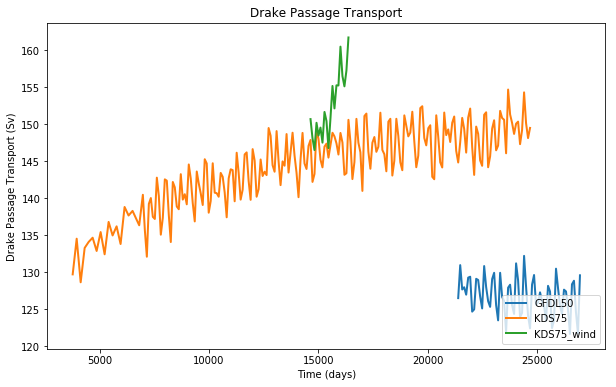

In [11]:
plt.figure(figsize=(10,6))

for expt in drake_transport:
    drake_transport[expt].plot(label=expt, linewidth=2)

plt.legend(loc='lower right')
plt.ylabel('Drake Passage Transport (Sv)')
plt.xlabel('Time (days)')
plt.title('Drake Passage Transport')
plt.savefig('figures/DPTrans.pdf')

# Scalar Quantities
Look at some quantities that are saved in ocean_scalar.nc.

In [12]:
def extract_data(f):
    dataset = Dataset(f)
    
    data = {}
    for v in dataset.variables.values():
        if 'time' in v.dimensions and 'scalar_axis' in v.dimensions:
            data[v.name] = v[:].flatten()
    index = pd.to_datetime(dataset['time'][:], unit='D')
    df = pd.DataFrame(index=index, data=data)
    return df

scalar_quantities = {}

for expt in expts:
    expdir = os.path.join(DataDir,expt)
    DataFileList = glob(os.path.join(expdir, 'output*/ocean_scalar.nc'))

    frames = [ delayed(extract_data)(f) for f in DataFileList]
    if len(frames) > 0:
        scalar_quantities[expt] = delayed(pd.concat)(frames).compute(get=client.get)

In [13]:
scalar_quantities['GFDL50'].describe().T

,count,mean,std,min,25%,50%,75%,max
eta_global,228.0,-1.599575e-02,6.501726e-03,-2.556028e-02,-2.260215e-02,-1.545898e-02,-9.247627e-03,-7.672984e-03
ke_tot,228.0,3.193163e+03,4.031690e+01,3.071416e+03,3.167506e+03,3.194453e+03,3.220488e+03,3.280610e+03
pe_tot,228.0,3.016919e+10,9.976375e+04,3.016908e+10,3.016915e+10,3.016919e+10,3.016932e+10,3.016941e+10
rhoave,228.0,1.056079e+03,1.923765e-03,1.056079e+03,1.056080e+03,1.056081e+03,1.056081e+03,1.056082e+03
salt_global_ave,228.0,3.471747e+01,5.367695e-05,3.471744e+01,3.471748e+01,3.471750e+01,3.471752e+01,3.471758e+01
salt_surface_ave,228.0,3.452980e+01,1.728035e-02,3.449669e+01,3.451737e+01,3.453279e+01,3.454316e+01,3.455881e+01
temp_global_ave,228.0,3.583088e+00,4.226761e-03,3.574442e+00,3.579929e+00,3.583148e+00,3.586063e+00,3.592330e+00
temp_surface_ave,228.0,1.812774e+01,1.752720e-01,1.783244e+01,1.803352e+01,1.811293e+01,1.826968e+01,1.842636e+01
total_net_sfc_heating,228.0,1.011368e-01,4.107090e+00,-7.338331e+00,-2.964327e+00,2.030339e+00,3.477559e+00,4.635539e+00
total_ocean_calving,228.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


CPU times: user 660 ms, sys: 468 ms, total: 1.13 s
Wall time: 616 ms


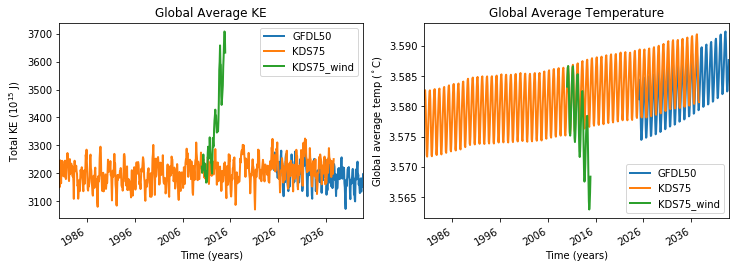

In [15]:
%%time

plt.figure(figsize=(12,4))

for expt in expts:
    plt.subplot(121)
    scalar_quantities[expt].ke_tot.plot(label=expt, linewidth=2)

    plt.subplot(122)
    scalar_quantities[expt].temp_global_ave.plot(label=expt, linewidth=2)

plt.subplot(121)
plt.legend(loc='upper right')
plt.ylabel('Total KE (10$^{15}$ J)')
plt.xlabel('Time (years)')
plt.title('Global Average KE')

plt.subplot(122)
plt.legend(loc='lower right')
plt.ylabel('Global average temp ($^\circ$C)')
plt.xlabel('Time (years)')
plt.title('Global Average Temperature')

plt.savefig('figures/Scalars.pdf')

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [30]:
def calculate_psi(expt):
    expdir = os.path.join(DataDir, expt)

    outList = [f for f in os.listdir(expdir) if f.startswith('output')]
    outList.sort()

    psi = 0
    ii=0
    for g in outList[-4:]: 
        ii+=1
        oceanfile = os.path.join(expdir,g,'ocean.nc')

        print (oceanfile)
        dsx = xr.open_dataset(oceanfile, decode_times=False, engine='h5netcdf', chunks={'grid_xt_ocean':600})
        psi_partial = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
        dsx.close()

        psi = psi + psi_partial

    psi_avg = psi/ii

    return psi_avg


In [31]:
psi_KDS = calculate_psi('KDS75')
psi_GFDL = calculate_psi('GFDL50')

/g/data1/v45/mom01_comparison/KDS75/output257/ocean.nc
/g/data1/v45/mom01_comparison/KDS75/output258/ocean.nc
/g/data1/v45/mom01_comparison/KDS75/output259/ocean.nc
/g/data1/v45/mom01_comparison/KDS75/output260/ocean.nc
/g/data1/v45/mom01_comparison/GFDL50/output400/ocean.nc
/g/data1/v45/mom01_comparison/GFDL50/output401/ocean.nc
/g/data1/v45/mom01_comparison/GFDL50/output402/ocean.nc
/g/data1/v45/mom01_comparison/GFDL50/output403/ocean.nc


In [32]:
def plot_psi(psi, expt, clev=np.arange(-20,20,2)):
    #x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

    plt.contourf(psi.grid_yu_ocean, psi.potrho, psi, cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

In [33]:
psi_KDS.load()

<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.246152e-04,
         -3.296911e-04,  -3.918397e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   1.932766e-04,
         -9.357884e-05,  -3.400682e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   1.147562e-04,
         -6.141737e-05,  -3.316848e-04],
       ..., 
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   1.954440e-04,
          8.408520e-05,  -1.359342e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   1.954440e-04,
          8.408520e-05,  -1.359342e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   1.954440e-04,
          8.408520e-05,  -1.359342e-04]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

In [34]:
%%time
psi_GFDL.load()

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 38.2 s


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.167051e-03,
         -1.426333e-03,  -7.789123e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.225597e-03,
         -1.537618e-03,  -8.594713e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.381589e-03,
         -1.609289e-03,  -1.203502e-03],
       ..., 
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   4.884031e-04,
          3.389723e-04,   3.144099e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   4.884031e-04,
          3.389723e-04,   3.144099e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   4.884031e-04,
          3.389723e-04,   3.144099e-05]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

In [35]:
psi_diff = psi_KDS - psi_GFDL

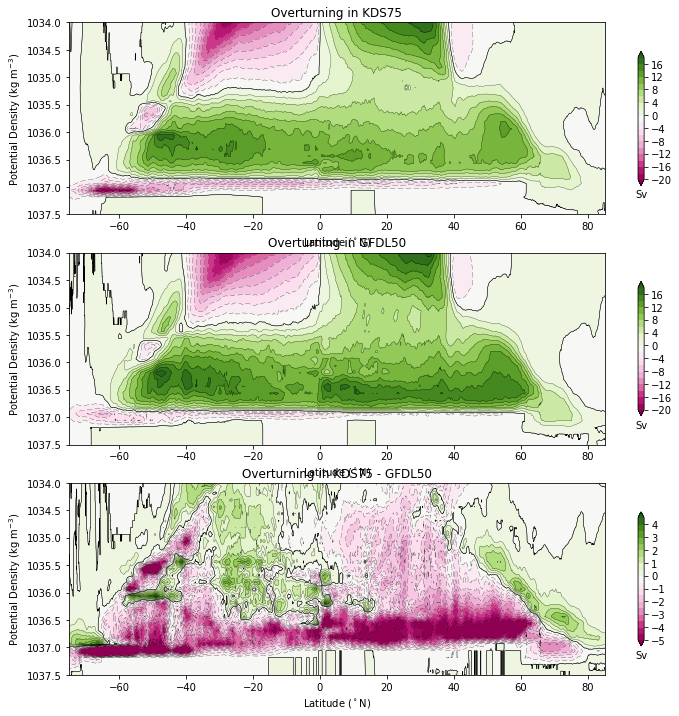

In [36]:
plt.figure(figsize=(12,12))

plt.subplot(311)
plot_psi(psi_KDS, 'KDS75')

plt.subplot(312)
plot_psi(psi_GFDL, 'GFDL50')

plt.subplot(313)
plot_psi(psi_diff, 'KDS75 - GFDL50', clev = np.arange(-5,5,0.5))

In [37]:
print ('For densities exceeding: ', psi_KDS.potrho[68].values)
print ('And at latitude:', psi_KDS.grid_yu_ocean[500].values)
print ('GFDL50 Min', np.min(psi_GFDL[68:,500]).values)
print ('KDS75 Min', np.min(psi_KDS[68:,500]).values)

For densities exceeding:  1036.5625
And at latitude: -59.4677023349844
GFDL50 Min -5.681802918310182
KDS75 Min -20.686767263540222


# Summary
* We discovered this
